# Comparing our algortihm against the primal dual algortihm by Jing et al. (2022)
In this experiment, we will compare our uncosntrained algortihm to the uncosntrained counterpart of the algorithm by Jing et al. in the setting where we know the exact solution i.e. the scaling case.

**Reference.**
Jing, Y., Chen, J., Li, L., & Lu, J. (2022). A deep learning framework for geodesics under spherical Wasserstein-Fisher-Rao metric and its application for weighted sample generation. arXiv. https://arxiv.org/abs/2208.12145

In [2]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
import matlab.engine
import io

# The theory
Since each algorithm addresses a different problem, we state their respective objective. The description will stay informal, and for more information, see the respective paper.

## Our algorithm
Our algorithm aims to solve the following problem:
$\begin{align} \textrm{minimize}_{\rho, \omega, \zeta, \bar{\rho}, \bar{\omega}, \bar{\zeta}} &\int_{0}^{1}\int_{\Omega} \frac{|\bar{\omega}|^2+\delta^2 \bar{\zeta}^2}{2\bar{\rho}}dxdt \\ \textrm{subject to } &\partial_t + \textrm{div}(\omega) = \zeta, I(\rho, \omega, \zeta) = (\bar{\rho}, \bar{\omega}, \bar{\zeta}),\end{align}  $

Here, $\rho, \omega$ amnd $ \zeta$ are the density, the momentum and the source term on the **staggered grid**, $\tilde{\rho}, \tilde{\omega}, \tilde{\zeta}$ are corresponding variables on the **centered grid**, $\delta>0$ is a constant and $I$ is the linear interpolation operator from the staggered grid to the centered grid. We will use Douglas-Rachford algorithm on the optimization variables $\rho, \omega, \zeta, \bar{\rho}, \bar{\omega}, \bar{\zeta}$ under an appropriate discrete representation of the above problem. On top of the interpolation parameter $\delta$, The DR algortihm introduces two parameters $\alpha, \gamma$ where the first parameter represents the step size and the second represents the scaling of the objective. We use the default values for these parameters.

## The algorithm in Jing et al. (2022)
The algorithm in Jing et al considers the Lagrangian of the following optimization problem with constraint.
$\begin{align} \textrm{minimize}_{\rho, \omega, \zeta} &\int_{0}^{1}\frac{|\omega|^2+\alpha \zeta^2}{2\rho}dxdt \\ \textrm{subject to } &\partial_t + \textrm{div}(\omega) = \zeta, \forall t, \int_{\Omega}\zeta dx = 0\end{align}  $
We notice that we do not use the staggered grid anymore and use the "usual" grid both in time and space. Moreover, the constarint $\int_{\Omega }\zeta dx = 1$ is replaced by $\int_{\Omega }\zeta dx = 0$ The latter is slightly weaker because it only says that the net change of the mass amount is zero i.e. the constant mass constraint, but along with the initial and the terminal condition satisying $\int_{\Omega }\zeta dx = 1$, the constraint in $\zeta$ is equivalent to the one in $\rho$. Written using the Lagrangian, the problem this algorithm solves is the following dual problem:

$\begin{align} \textrm{max}_{\phi, \lambda}\textrm{min}_{\rho, \omega, \zeta} &\sum_{t=1}^{N_t}\int_{\Omega} \frac{|\omega_t|^2+\alpha \zeta_t^2}{2\rho_t}dx  + \left\langle \phi_t, \frac{\rho_{t+1}-\rho_t}{\Delta t} + \nabla\cdot \omega_t -\zeta_t \right\rangle \end{align}  $

Here, $\phi$ and $\lambda$ are Lagrange coefficients, where $\phi$ is a function of space and time, $\lambda$ is a function of time, $N_t$ represents the size of the time grid, and $\langle \cdot, \cdot \rangle$ denotes the $L^2$ inner product with respect to the space variable.

This algorithm has three parameters: $\alpha$ for the interpolation, which corresponds to $\delta^2 $ in our algorithm, $\mu, \tau$ for the step sizes. We use the default parameters used in their code.


# Set up
Here, we will create the densities we will use for the transport. We consider the domain $[0,1]$ and the following two densities:

$\rho_0(x) = \frac{1}{3} N(x|0.25, 1/10) + \frac{2}{3}N(x, 0.75, 1/10)$


$\rho_1(x) = 0.5\rho_0(x)$

where $N(x|\mu, \sigma^2)$ denotes the pdf of normal distribtuion of mean $\mu$ and variance $\sigma^2$.


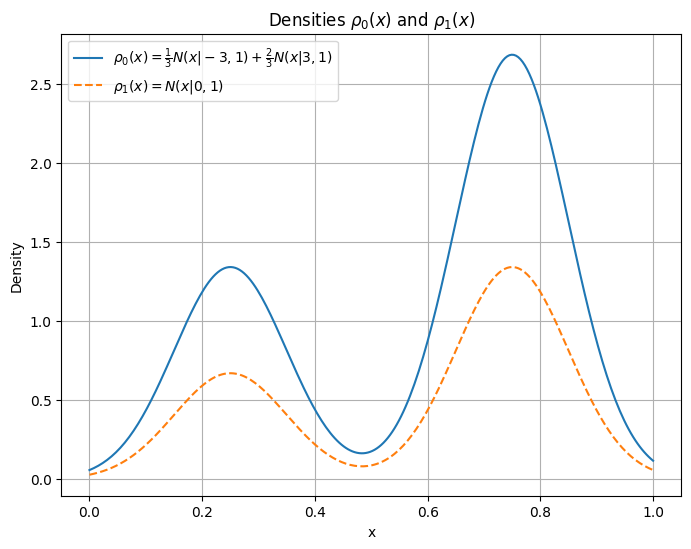

In [3]:
# Parameters
Nx = 256 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.0007 # Originally 0.007
tao = 0.0007 # Originally 0.007
N_itr = 10000  # Originally 1000000
X = [0, 1] # Originally [-7, 7]
T = [0, 1]

dx = (X[1] - X[0]) / Nx
dt = 1 / Nt

x_space = np.linspace(X[0], X[1], Nx)
t_space = np.linspace(T[0], T[1], Nt)

# The initial density
# Compute densities
rho_0 = (1/3) * sp.stats.norm.pdf(x_space, loc=0.25, scale=1/10) + (2/3) * sp.stats.norm.pdf(x_space, loc=0.75, scale=1/10)
# Scale so that the integral is 1
rho_0 = rho_0 / np.sum(rho_0 * dx)
scaling_param = 0.5
rho_1 = scaling_param * rho_0

# Plot the densities
plt.figure(figsize=(8, 6))
plt.plot(x_space, rho_0, label=r"$\rho_0(x) = \frac{1}{3} N(x|-3, 1) + \frac{2}{3} N(x|3, 1)$")
plt.plot(x_space, rho_1, label=r"$\rho_1(x) = N(x|0, 1)$", linestyle='--')
plt.xlabel("x")
plt.ylabel("Density")
plt.title(r"Densities $\rho_0(x)$ and $\rho_1(x)$")
plt.legend()
plt.grid()
plt.show()

# Our algortihm
We will now calculate the geodesic using our algortihm.

In [4]:
ll = (1.0, X[1]-X[0]) # size of time x space box
x_ours, lists = computeGeodesic(rho_0, rho_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)

Computing a geodesic for optimal transport with source...
Initial energy: 0.0
Progress: 99%
Done.


# Plotting the result

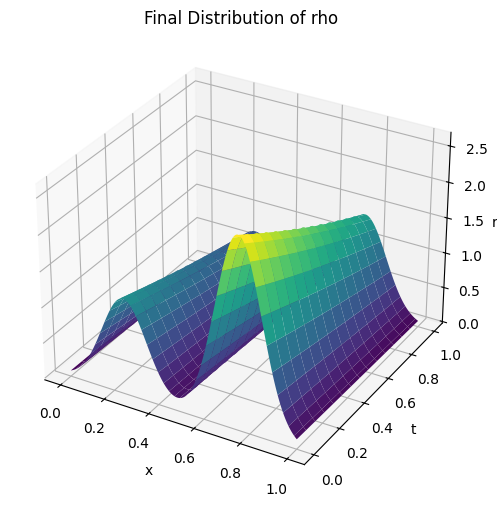

In [4]:
# Step 8: Plot rho_opt as a 3D surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
X_mesh, T_mesh = np.meshgrid(x_space, t_space)
ax.plot_surface(X_mesh, T_mesh, x_ours.V.D[0], cmap='viridis')

# Customize plot
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('rho')
ax.set_title('Final Distribution of rho')

# Show plot
plt.show()

In [5]:
def plot_1Dn(t, x, v, g, X, rho_0, rho_1, ylim=[-2, 2], title="" , mplier=1.0):
    plt.figure(figsize=[16, 4])

    # Fill plots
    if rho_0 is not None:
        plt.fill_between(X, rho_0, color="k", alpha=0.2, label=r'$\rho_0$')
    if rho_1 is not None:
        plt.fill_between(X, rho_1, color="b", alpha=0.2, label=r'$\rho_1$')
    plt.fill_between(X, x.V.D[0][t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')

    # Line plots
    plt.plot(X, mplier*v[0][t, :], "k", label=r'$v_t$')
    plt.plot(X, mplier*g[t, :], "g", label=r'$g_t$')
    plt.title(title)
    plt.axis([0, 1, ylim[0], ylim[1]])
    plt.show()

v,g = speed_and_growth(x_ours.V)
plot_elements2 = [x_ours.copy(), v.copy(), g.copy(), x_space.copy(), None, None, [-0.5,3], r"(red) $\rho_t$ (green) $g_t$ (dark) $v_t$", 0.1]
interact(lambda t: plot_1Dn(t, *plot_elements2), t=widgets.IntSlider(min=0, max=Nt-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

# Jing et al. (2022)
We will now run the algortihm by Jing et al. (2022)

In [6]:
output_buffer = io.StringIO()

print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()

print('📜 Running WFR_main.m...')
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)
eng.workspace['Nx'] = float(Nx)
eng.workspace['Nt'] = float(Nt)
eng.workspace['alpha'] = float(alpha)
eng.workspace['mu'] = mu
eng.workspace['tao'] = tao
eng.workspace['N_itr'] = N_itr
eng.workspace['X'] = X
eng.workspace['T'] = T
eng.workspace['dx'] = dx
eng.workspace['dt'] = dt
eng.workspace['x_space'] = matlab.double(x_space.tolist())
eng.workspace['t_space'] = matlab.double(t_space.tolist())
eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
eng.workspace['rho_1'] = matlab.double(rho_1.tolist())

eng.WFR_main(nargout=0, stdout=output_buffer)

print("📤 Retrieving results from MATLAB... 🧩")
rho_opt = eng.workspace['rho_opt'] 
D = eng.workspace['D']  # The squared SWFR distance
Flist = np.array(eng.workspace['Flist'])  # The list of energy values at each iteration

# Step 5: Convert rho_opt to a NumPy array
rho_opt_np = np.array(rho_opt)

# Step 6: Stop the MATLAB Engine
eng.quit()
print("✨ MATLAB Engine stopped. 🌟")

# rough estimate of the runtime: 25-8=17 seconds

✨ Starting MATLAB Engine... 🛠️
📜 Running WFR_main.m...
📤 Retrieving results from MATLAB... 🧩
✨ MATLAB Engine stopped. 🌟


🔍 Shape of rho_opt: (15, 256)


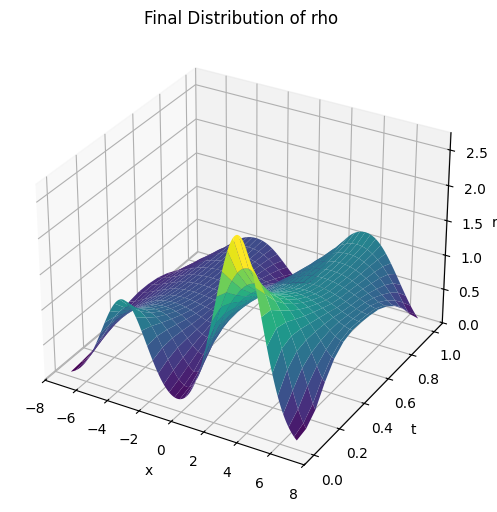

In [7]:
# Step 6: Print and check the shape of rho_opt
print("🔍 Shape of rho_opt:", rho_opt_np.shape)

# Step 7: Generate a meshgrid for plotting
Nx = rho_opt_np.shape[1]  # Number of spatial points
Nt = rho_opt_np.shape[0]  # Number of time steps
x = np.linspace(-7+dx, 7, Nx)  # Replace with spatial domain bounds
t = np.linspace(0, 1, Nt)  # Replace with time domain bounds
X, T = np.meshgrid(x, t)

# Step 8: Plot rho_opt as a 3D surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, T, rho_opt_np, cmap='viridis')

# Customize plot
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('rho')
ax.set_title('Final Distribution of rho')

# Show plot
plt.show()

In [8]:
def plot_1D(t, x, v, g, X, rho_0, rho_1, ylim=[-2, 2], title="" , mplier=1.0):
    plt.figure(figsize=[16, 4])

    plt.fill_between(X, x[t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    plt.title(title)
    plt.axis([0, 1, ylim[0], ylim[1]])

plot_elements3 = [rho_opt_np.copy(), None, None, x_space.copy(), None, None, [-0.5,3], r"(red) $\rho_t$", 0.1]
interact(lambda t: plot_1D(t, *plot_elements3), t=widgets.IntSlider(min=0, max=Nt-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(t)>

# Combined Results

# The WFR distance

In [9]:
print(f'The WFR distance (ours):{np.sqrt(x_ours.V.energy(delta=1.0, p=2.0, q=2.0))}')
print(f'The WFR distance (Jing et al. 2022):{np.sqrt(D*dx*dt)}')
print(f'The WFR distance (exact): {delta*np.abs(np.sqrt(scaling_param)-1)*np.sqrt(2)}')
# The errors between the exact solutions and the two algorithms
print(f'The error between the exact solution and ours: {np.abs(np.sqrt(x_ours.V.energy(delta=1.0, p=2.0, q=2.0)) - delta*np.abs(np.sqrt(0.5)-1)*np.sqrt(2))}')
print(f'The error between the exact solution and Jing et al. 2022: {np.abs(np.sqrt(D*dx*dt) - delta*np.abs(np.sqrt(0.5)-1)*np.sqrt(2))}')

The WFR distance (ours):0.4141856508525952
The WFR distance (Jing et al. 2022):0.41444009798279285
The WFR distance (exact): 0.41421356237309503
The error between the exact solution and ours: 2.7911520499857012e-05
The error between the exact solution and Jing et al. 2022: 0.00022653560969781994


# Energy value at each iteration

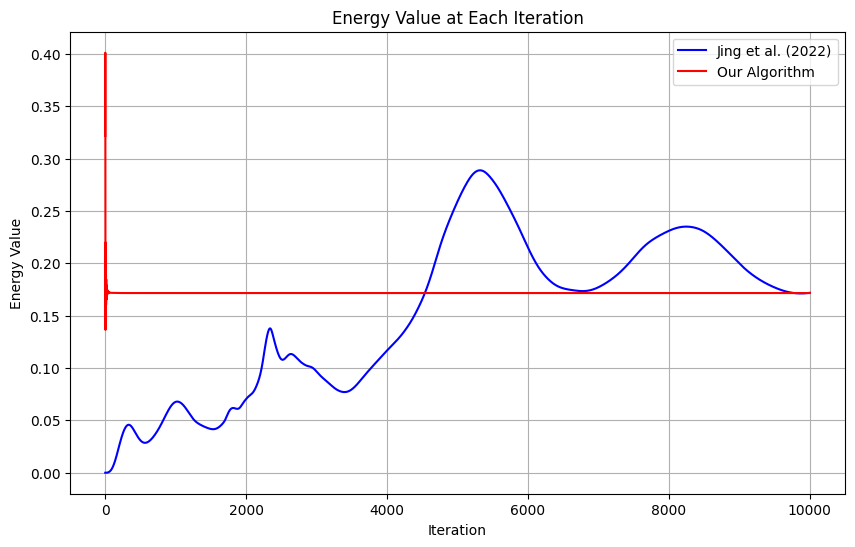

In [10]:
# Plotting the energy values at each iteration for both algorithms
plt.figure(figsize=(10, 6))
plt.plot(Flist, label='Jing et al. (2022)', color='blue')
plt.plot(lists[0], label='Our Algorithm', color='red')
plt.xlabel('Iteration')
plt.ylabel('Energy Value')
plt.title('Energy Value at Each Iteration')
plt.legend()
plt.grid()
plt.show()

In [15]:
lists[0]

array([0.32161811, 0.40101621, 0.24620765, ..., 0.17154975, 0.17154975,
       0.17154975])

# Combined density plot


interactive(children=(IntSlider(value=0, description='t', max=14), Output()), _dom_classes=('widget-interact',…

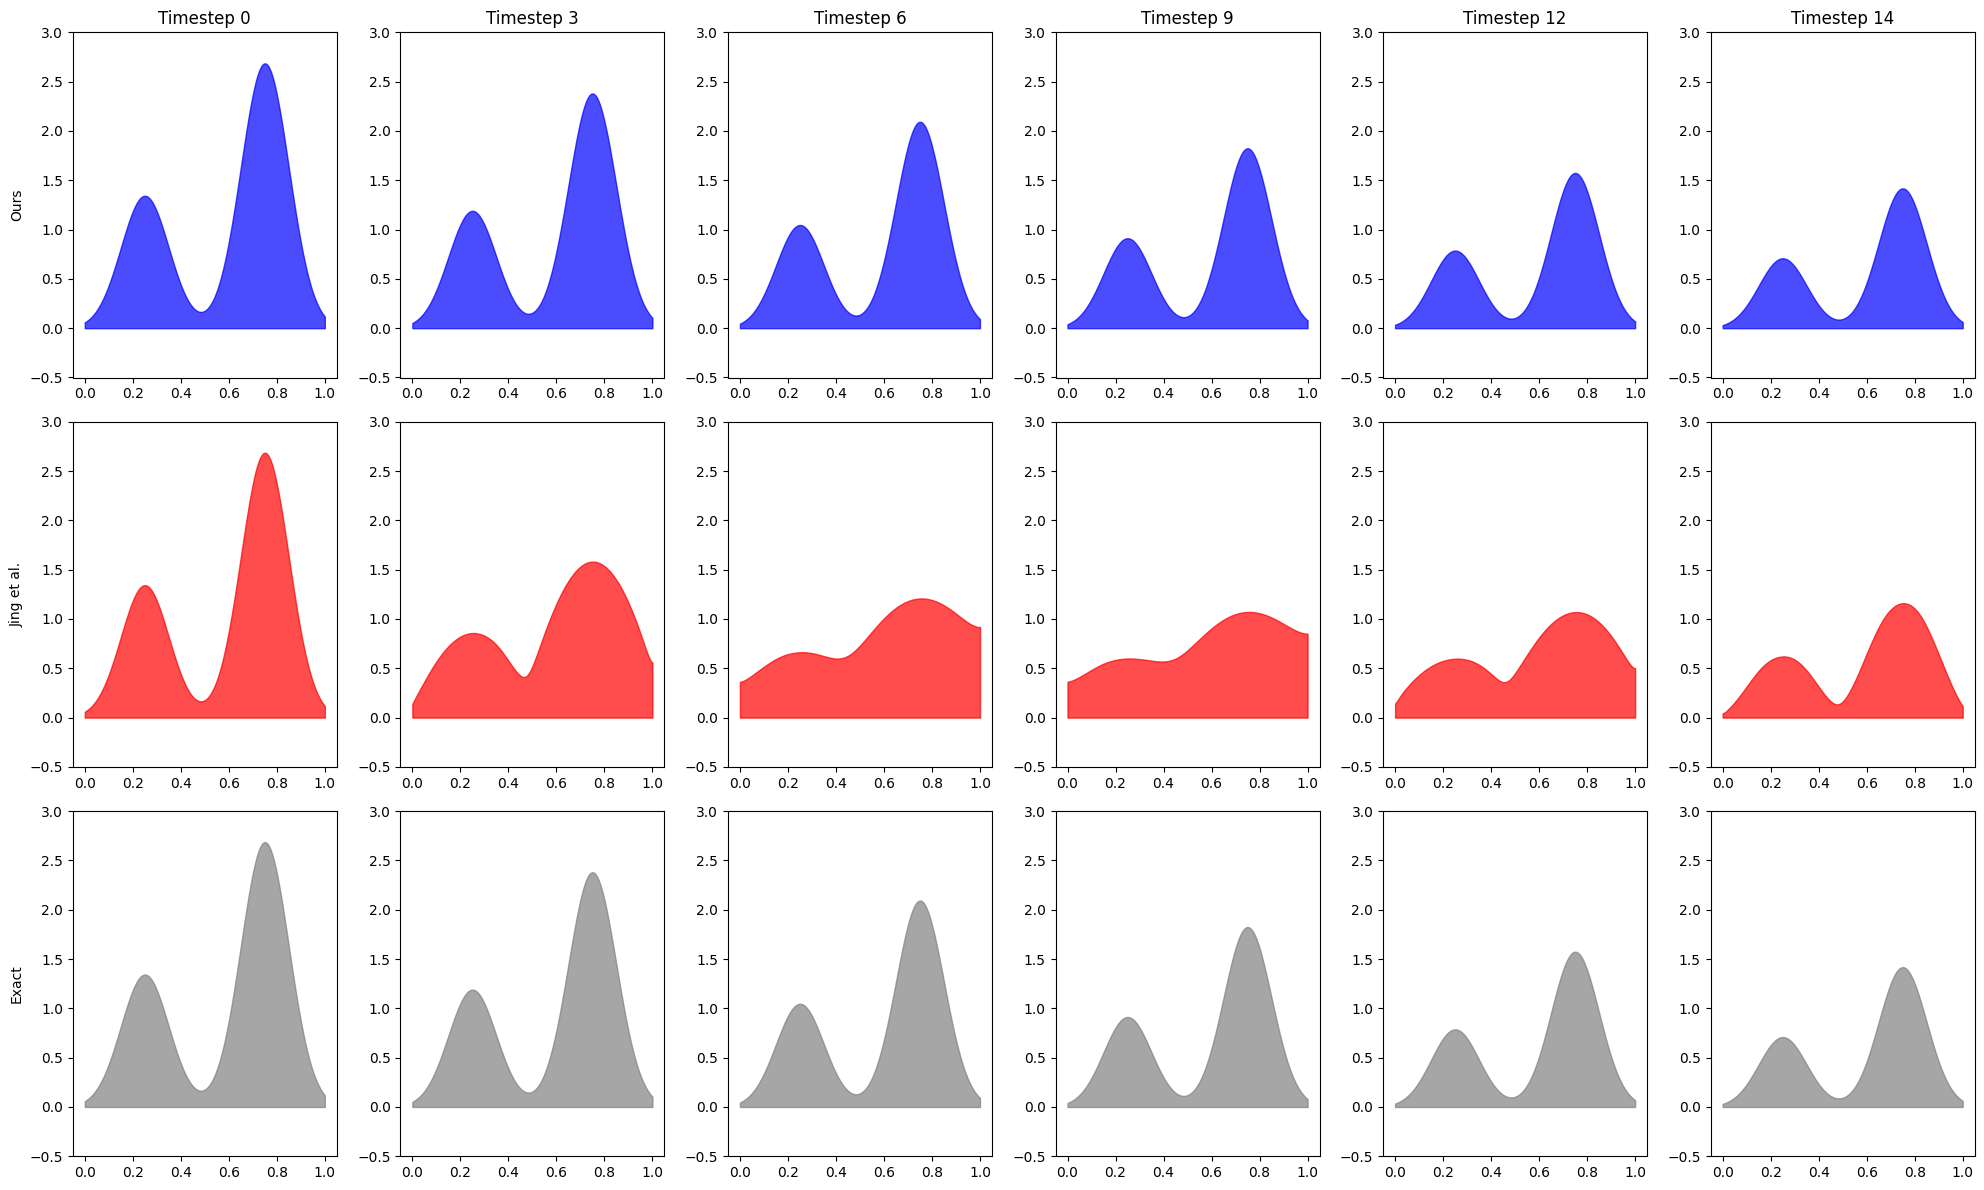

In [14]:
def plot_1D3(t, x, x_ours, X, ylim=[-2, 2], title="" , mplier=1.0):
    plt.figure(figsize=[16, 4])

    plt.fill_between(X, x_ours.U.D[0][t, :], color="b", alpha=0.2, label=r'$\rho_{t}$')
    plt.fill_between(X, x[t, :], color="r", alpha=0.7, label=r'$\rho_{t}$')
    plt.fill_between(X, ((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0, color="r", alpha=0.2, label=r'$\rho_0$')
    plt.title(title)
    plt.axis([0, 1, ylim[0], ylim[1]])

plot_elements4 = [rho_opt_np.copy(), x_ours, x_space.copy(), [-0.5,3], r"Red -  Jing et al.,  Blue - Ours, Gray - Exact", 0.1]
interact(lambda t: plot_1D3(t, *plot_elements4), t=widgets.IntSlider(min=0, max=Nt-1, step=1, value=0))
# Static plot for selected timesteps
timesteps = [0, 3, 6, 9, 12, 14]
fig, axes = plt.subplots(3, len(timesteps), figsize=(20, 12))

for i, t in enumerate(timesteps):
    # Plot for our algorithm
    axes[0, i].fill_between(x_space, x_ours.U.D[0][t, :], color="b", alpha=0.7)
    axes[0, i].set_title(f'Timestep {t}')
    axes[0, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[0, i].set_ylabel('Ours')

    # Plot for Jing et al. (2022)
    axes[1, i].fill_between(x_space, rho_opt_np[t, :], color="r", alpha=0.7)
    axes[1, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[1, i].set_ylabel('Jing et al.')

    # Plot for exact solution
    exact_rho = ((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0
    axes[2, i].fill_between(x_space, exact_rho, color="gray", alpha=0.7)
    axes[2, i].set_ylim([-0.5, 3])
    if i == 0:
        axes[2, i].set_ylabel('Exact')

plt.tight_layout()
plt.show()

# $L^2$ error between the exact solution

We observe that our error is much smaller.

In [12]:
# Calculate the exact solution
exact_solution = np.array([((t/Nt)*np.sqrt(scaling_param)+(1-(t/Nt)))**2 * rho_0 for t in range(Nt)])

# Calculate the L2 error
l2_error = np.sqrt(np.sum((rho_opt_np - exact_solution)**2) * dx * dt)

# Print the L2 error
print(f'The L2 error between the exact solution and the computed solution: {l2_error}')
# Calculate the L2 error for our algorithm
l2_error_ours = np.sqrt(np.sum((x_ours.U.D[0][:-1] - exact_solution)**2) * dx * dt)

# Print the L2 error for our algorithm
print(f'The L2 error between the exact solution and our algorithm: {l2_error_ours}')

The L2 error between the exact solution and the computed solution: 0.3450164496465666
The L2 error between the exact solution and our algorithm: 8.370960133048695e-05
